# Sport and health data analysis

## Project: garmin2data

## Objective: use performance and health metrics to generate information

#### Import Python libraries

In [1]:
import json
import folium
import math
import pandas as pd
import seaborn as sns
from datetime import datetime

#### Garmin data

Raw data cannot be accessed through APIs, the user has to directly request it at Garmin's website. The user receives an email with all its stored information. After unzipping and organizing, the files can be accessed using the following lines.

In [2]:
# json with fitness data dataset 1
with open('data/DI_CONNECT/DI-Connect-Fitness/leaofrigo@gmail.com_0_summarizedActivities.json') as f:
  data_act = json.load(f)

# json with fitness data dataset 2
with open('data/DI_CONNECT/DI-Connect-Fitness/leaofrigo@gmail.com_1001_summarizedActivities.json') as f:
  data_act_2 = json.load(f)

# json with resting data (resting heart rate)
with open('data/DI_CONNECT/DI-Connect-User/UDSFile_2019-01-02_2019-04-12.json') as f:
  data_rst = json.load(f)

#### Data wrangling

In [3]:
# check data for one day
minHeartRate=data_rst[0]['minHeartRate']
maxHeartRate=data_rst[0]['maxHeartRate']
restingHeartRate=data_rst[0]['restingHeartRate']
restingHeartRateTimestamp=data_rst[0]['restingHeartRateTimestamp']

# get available activities
actv_list=[]
for i in range(0,len(data_act[0]['summarizedActivitiesExport'])):
    actv_list.append(data_act[0]['summarizedActivitiesExport'][i]['activityType'])
for i in range(0,len(data_act_2[0]['summarizedActivitiesExport'])):
    actv_list.append(data_act_2[0]['summarizedActivitiesExport'][i]['activityType'])

# get unique activities
actv_set = set(actv_list)

# parameters to get data
list_parameters=['activityType', 'name', 'beginTimestamp', 'duration', 'distance', 'avgSpeed', 'avgHr', 'maxHr', 'elevationGain', 'elevationLoss', 'calories', 'movingDuration', 'elapsedDuration', 'minTemperature', 'maxTemperature', 'endLongitude', 'endLatitude']

# get list of data
actv_raw_data=[]
# dataset data_act
for i in range(0,len(data_act[0]['summarizedActivitiesExport'])):
    temp_list=[]
    for j in list_parameters:
        try:
            temp_list.append(data_act[0]['summarizedActivitiesExport'][i][j])
        except:
            temp_list.append(float('NAN'))
    actv_raw_data.append(temp_list)

# dataset data_act_2
for i in range(0,len(data_act_2[0]['summarizedActivitiesExport'])):
    temp_list=[]
    for j in list_parameters:
        try:
            temp_list.append(data_act_2[0]['summarizedActivitiesExport'][i][j])
        except:
            temp_list.append(float('NAN'))
    actv_raw_data.append(temp_list)

# convert timestamp to date time (was not possible to easily convert with Pandas)
datetime_list=[]
for i in range(0,len(actv_raw_data)):
    temp_val = actv_raw_data[i][2]
    if math.isnan(temp_val):
        datetime_list.append(float('NAN'))
    else:
        datetime_list.append(datetime.utcfromtimestamp(float(actv_raw_data[i][2])/1000).strftime('%Y-%m-%d'))
        
# list to dataframe
df = pd.DataFrame(actv_raw_data,columns=list_parameters)
df['datetime'] = datetime_list

# inspect and fix  gps wrong data
# for the trainings in Boca Ratton (USA) the GPS didn't work well, so we can manually add lat/lon
df.loc[df['name'].str.contains('Boca', case=False), 'endLongitude'] = '-80.1289321'
df.loc[df['name'].str.contains('Boca', case=False), 'endLatitude'] = '26.3683064'
# some training sessions also had wrong gps inserted as [0,0], so we drop them
df = df.loc[~((df['endLongitude']==0) & (df['endLatitude']==0)),:]

# convert distances from cm to m
df['distance']=df['distance']/100

# convert elevations from mm to m
df['elevationGain']=df['elevationGain']/1000
df['elevationLoss']=df['elevationLoss']/1000

# convert duration from ms to s
df['duration']=df['duration']/1000
df['movingDuration']=df['movingDuration']/1000
df['elapsedDuration']=df['elapsedDuration']/1000

# convert speed from cm/s to km/h
df['avgSpeed']=df['avgSpeed']*36

# convert calories from joules to calories
df['calories']=df['calories']*0.239006

# datetime.utcfromtimestamp((df['beginTimestamp'])).strftime('%Y-%m-%d')
df['distance']=df['distance']/1000

#### Create a map to visualize places with recorded activities

In [4]:
# create map with activities
actv_map = folium.Map(location=[0, 0], zoom_start=2)

# create list of markers
df2map = df[['activityType','endLatitude','endLongitude']].dropna()
map_label = df2map[['activityType']].values.tolist()
map_latlon = df2map[['endLatitude','endLongitude']].values.tolist()

# add markers 
for point in range(0, len(map_latlon)):
    folium.Marker(map_latlon[point],  popup=map_label[point]).add_to(actv_map)

In [5]:
# call the map
actv_map

#### Overview of the database

In [6]:
df.head(10)


,activityType,name,beginTimestamp,duration,distance,avgSpeed,avgHr,maxHr,elevationGain,elevationLoss,calories,movingDuration,elapsedDuration,minTemperature,maxTemperature,endLongitude,endLatitude,datetime
0,running,Frankfurt am Main Running,1.615389e+12,3404.163086,10.00877,10.58400,153.0,167.0,10.9,5.6,796.144736,3387.000000,3794.403076,12.0,22.0,8.68297,50.155,2021-03-10
1,indoor_cycling,Bike indoor,1.615310e+12,3600.000000,30.00000,30.00000,NaN,NaN,NaN,NaN,943.356405,NaN,0.000000,NaN,NaN,NaN,NaN,2021-03-09
2,walking,Frankfurt am Main Walking,1.615121e+12,427.661987,0.75085,6.32160,110.0,126.0,1.4,0.0,53.076316,423.000000,427.661987,16.0,23.0,8.68312,50.1545,2021-03-07
3,trail_running,Schmitten Trail Running,1.615112e+12,4898.324219,15.00609,11.03040,155.0,173.0,18.8,68.7,1130.625670,4857.431030,5744.323242,11.0,17.0,8.45476,50.2248,2021-03-07
4,trail_running,Oberursel (Taunus) Trail Running,1.615106e+12,4550.276855,10.89484,8.61840,157.0,175.0,64.8,0.0,1079.552234,4527.337006,5087.982910,7.0,18.0,8.54859,50.2151,2021-03-07
5,indoor_cardio,Cardio,1.614968e+12,3603.347900,0.00000,0.00000,84.0,153.0,0.0,0.0,224.322542,0.000000,3649.537109,23.0,26.0,NaN,NaN,2021-03-05
6,running,Frankfurt am Main Running,1.614852e+12,3621.232910,12.10452,12.03480,158.0,194.0,11.4,5.5,898.291608,3606.000000,4231.227051,14.0,24.0,8.68213,50.1538,2021-03-04
7,indoor_cycling,Indoor Cycling,1.614786e+12,3600.940918,30.00000,29.99216,89.0,133.0,NaN,NaN,280.403178,0.000000,3627.060059,24.0,27.0,NaN,NaN,2021-03-03
8,running,Frankfurt am Main Running,1.614703e+12,586.643005,2.20104,13.50720,151.0,165.0,9.0,0.2,140.201589,583.000000,782.671997,18.0,22.0,8.68337,50.1542,2021-03-02
9,running,Frankfurt am Main Running,1.614701e+12,1672.281982,6.00069,12.91680,153.0,175.0,5.0,5.5,404.581728,1663.000000,1767.170044,17.0,25.0,8.67752,50.1707,2021-03-02


#### Histograms and description for running activities parameters

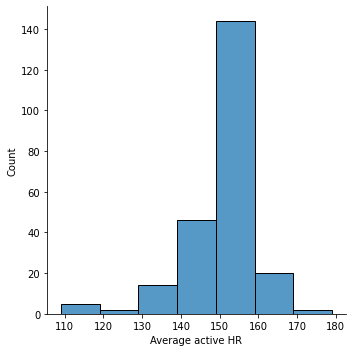

In [7]:
# activity avg HR (running)
desc_avgHr=df.avgHr[df.activityType.isin(['running'])].describe()
hist_avgHr_df=df.avgHr[df.activityType.isin(['running'])]
hist_avgHr_df = pd.Series(hist_avgHr_df, name="Average active HR")
hist_avgHr = sns.displot(hist_avgHr_df,binwidth=10)


In [8]:
desc_avgHr

count    233.000000
mean     150.004292
std        9.172437
min      109.000000
25%      148.000000
50%      151.000000
75%      155.000000
max      179.000000
Name: avgHr, dtype: float64

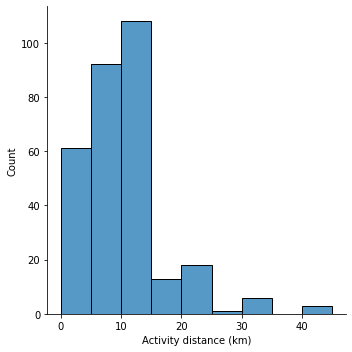

In [9]:
# activity distance (running)
desc_distance=df.distance[df.activityType.isin(['running'])].describe()
hist_distance_df=df.distance[df.activityType.isin(['running'])]
hist_distance_df = pd.Series(hist_distance_df, name="Activity distance (km)")
hist_distance = sns.displot(hist_distance_df,binwidth=5)

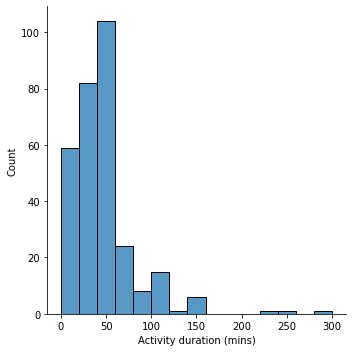

In [10]:
# activity duration (running)
desc_duration=df.duration[df.activityType.isin(['running'])].describe()
hist_duration_df=df.duration[df.activityType.isin(['running'])]
hist_duration_df = pd.Series(hist_duration_df/60, name="Activity duration (mins)")
hist_duration = sns.displot(hist_duration_df,binwidth=20)

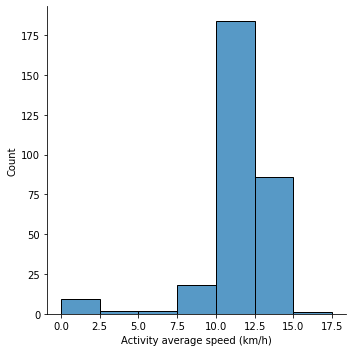

In [11]:
# activity duration (running)
desc_avgspeed=df.avgSpeed[df.activityType.isin(['running'])].describe()
hist_avgspeed_df=df.avgSpeed[df.activityType.isin(['running'])]
hist_avgspeed_df = pd.Series(hist_avgspeed_df, name="Activity average speed (km/h)")
hist_avgspeed = sns.displot(hist_avgspeed_df,binwidth=2.5)

In [28]:
list_parameters_corr=['duration', 'distance', 'avgSpeed', 'avgHr', 'maxHr', 'calories']
df_run=df[df.activityType.isin(['running'])]
df_run_corr=df_run[list_parameters_corr]
corr = df_run_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,duration,distance,avgSpeed,avgHr,maxHr,calories
duration,1.000000,0.972616,0.015513,0.366072,0.447290,0.968140
distance,0.972616,1.000000,0.143174,0.396684,0.485492,0.980669
avgSpeed,0.015513,0.143174,1.000000,0.155826,0.075848,0.083404
avgHr,0.366072,0.396684,0.155826,1.000000,0.842609,0.448266
maxHr,0.447290,0.485492,0.075848,0.842609,1.000000,0.526548
calories,0.968140,0.980669,0.083404,0.448266,0.526548,1.000000


In [38]:
df_run_tail
df_run_corr=df_run_tail[list_parameters_corr]
corr = df_run_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,duration,distance,avgSpeed,avgHr,maxHr,calories
duration,1.000000,0.966742,0.190468,0.046592,0.212124,0.929920
distance,0.966742,1.000000,0.313869,0.135649,0.287645,0.976548
avgSpeed,0.190468,0.313869,1.000000,0.300938,0.000141,0.318531
avgHr,0.046592,0.135649,0.300938,1.000000,0.811149,0.232868
maxHr,0.212124,0.287645,0.000141,0.811149,1.000000,0.388389
calories,0.929920,0.976548,0.318531,0.232868,0.388389,1.000000
